In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_context('poster')

In [56]:
import pandas as pd

In [3]:
from kid_readout.interactive import *

INFO: 2016-05-19 14:21:52,679 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [28]:
from kid_readout.analysis.timedomain.filters import lpf

In [4]:
import glob

In [11]:
files = glob.glob('/data/readout/2016-05-19_14[23]*.nc')
files.sort()

In [12]:
files

['/data/readout/2016-05-19_142616_dark_28_dB_dac_0.0_mA_led.nc',
 '/data/readout/2016-05-19_142740_dark_28_dB_dac_0.1_mA_led.nc',
 '/data/readout/2016-05-19_142900_dark_28_dB_dac_1.0_mA_led.nc',
 '/data/readout/2016-05-19_143021_dark_28_dB_dac_2.0_mA_led.nc',
 '/data/readout/2016-05-19_143141_dark_28_dB_dac_4.0_mA_led.nc',
 '/data/readout/2016-05-19_143301_dark_28_dB_dac_8.0_mA_led.nc']

In [13]:
ncs = [NCFile(fn) for fn in files]

In [14]:
ons = [basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray2) for nc in ncs]
offs = [basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray1) for nc in ncs]
mods = [basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray3) for nc in ncs]


In [199]:
sson0 = [ssa.sweep_stream(4) for ssa in ons]
ssoff0 = [ssa.sweep_stream(4) for ssa in offs]
ssmod0 = [ssa.sweep_stream(4) for ssa in mods]
ssoff7 = [ssa.sweep_stream(7) for ssa in offs]

In [144]:
sns.color_palette?

# LED response

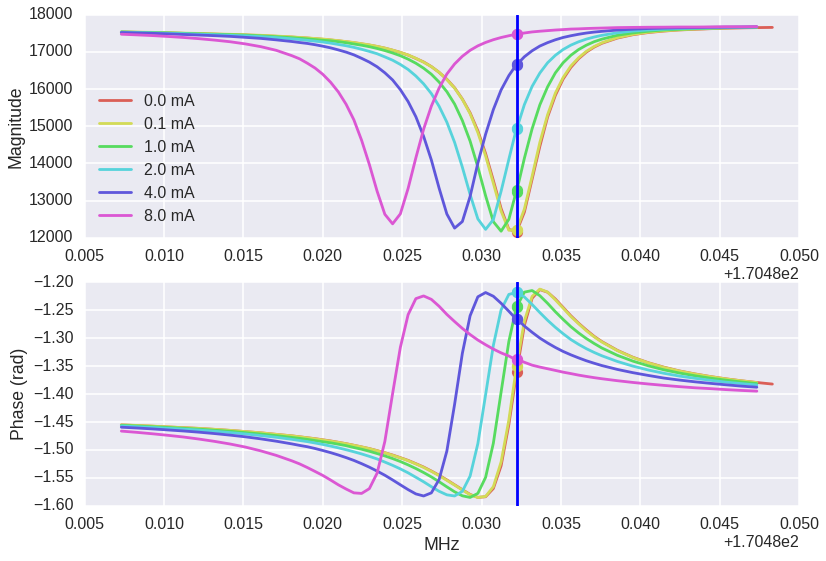

In [166]:
subplot(211)
for color,ss in zip(colors,sson0):
    plot(ss.sweep.frequency_MHz,np.abs(ss.sweep.s21_point),color=color,label=('%.1f mA' % (1e3*ss.stream.state.sourcemeter.current)))
    mask = ss.sweep.frequency_MHz==ss.stream.frequency_MHz
    plot(ss.sweep.frequency_MHz[mask],np.abs(ss.sweep.s21_point)[mask],'o',color=color)
axvline(ss.stream.frequency_MHz)
ylabel('Magnitude')
legend(loc='lower left',prop=dict(size='small'))
subplot(212)
for color,ss in zip(colors,sson0):
    plot(ss.sweep.frequency_MHz,np.angle(ss.sweep.s21_point),color=color)
    mask = ss.sweep.frequency_MHz==ss.stream.frequency_MHz
    plot(ss.sweep.frequency_MHz[mask],np.angle(ss.sweep.s21_point)[mask],'o',color=color)
axvline(ss.stream.frequency_MHz)
xlabel('MHz')
ylabel('Phase (rad)')


# LED response in the IQ plane

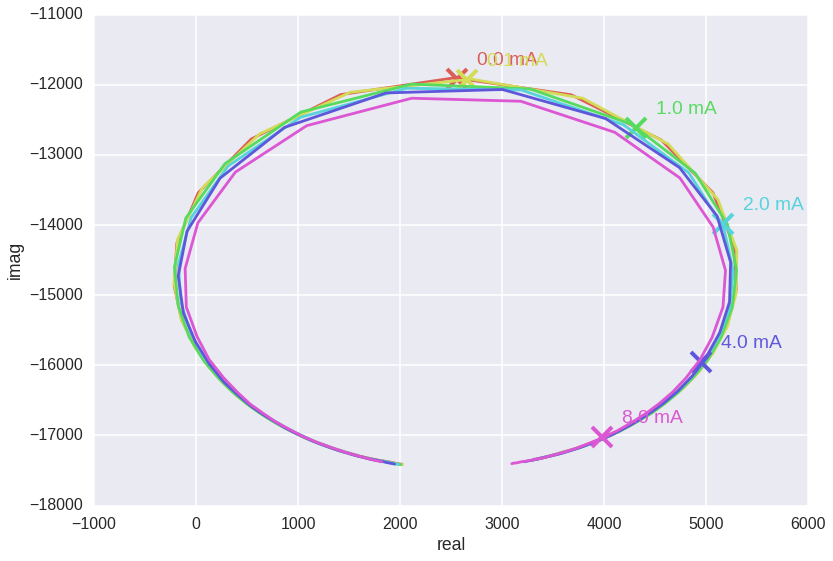

In [167]:
cutoff=1/128.
decimate_by = 128
num_taps = 1024
colors = sns.color_palette('hls',n_colors=len(sson0))
for color,ss in zip(colors,sson0):
    lp = lpf(ss.stream.s21_raw,cutoff=cutoff,num_taps=num_taps,decimate_by=decimate_by)

    plot_ri(ss.sweep.s21_point,'-',color=color)
    plot_ri(lp.mean(),'x',color=color,mew=4,ms=20)
    text(lp.mean(0).real+200,lp.mean(0).imag+200,('%.1f mA' % (1e3*ss.stream.state.sourcemeter.current)),color=color)
xlabel('real')
ylabel('imag')
#for ss in ssoff0:
#    plot_ri(ss.stream.s21_raw[:1000],'k,')
#for ss in ssmod0:
#    plot_ri(ss.stream.fold(ss.stream.s21_raw))

# Timeseries data from resonator

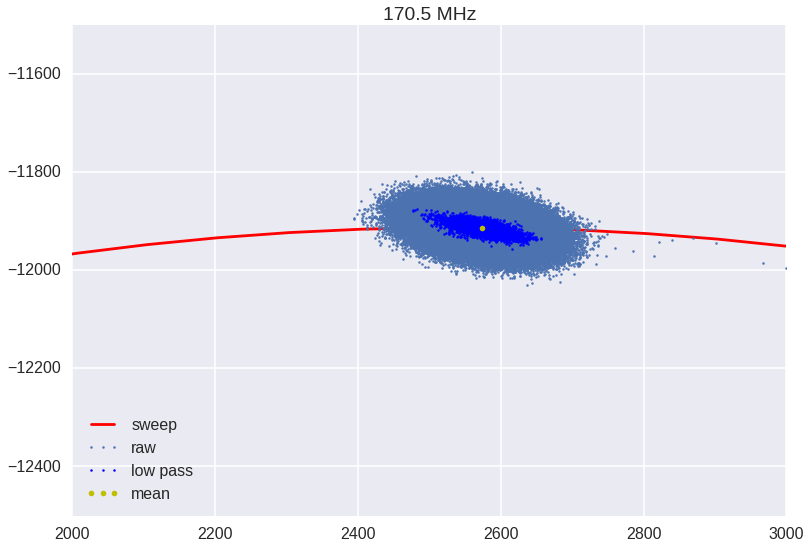

In [205]:
ss = ssoff0[0]
#plot_ri(ss.sweep.s21_point,'.')
sweep = ss.sweep
finef = np.linspace(sweep.frequency.min(),sweep.frequency.max(),1000)
fines21 = sweep.resonator.model.eval(params=sweep.resonator.current_params,f=finef)
plot_ri(fines21,'r',label='sweep')
plot_ri(ss.stream.s21_raw,'.',ms=5,label='raw')
lp = lpf(ss.stream.s21_raw,cutoff=cutoff,num_taps=num_taps,decimate_by=decimate_by)
plot_ri(lp,'b.',ms=5,label='low pass')
plot_ri(ss.stream.s21_point,'y.',label='mean')
xlim(2000,3000)
ylim(-12500,-11500)
legend(loc='lower left',numpoints=3)
title('%.1f MHz' % (sweep.resonator.f_0/1e6))

# Timeseries off resonance (for comparison)

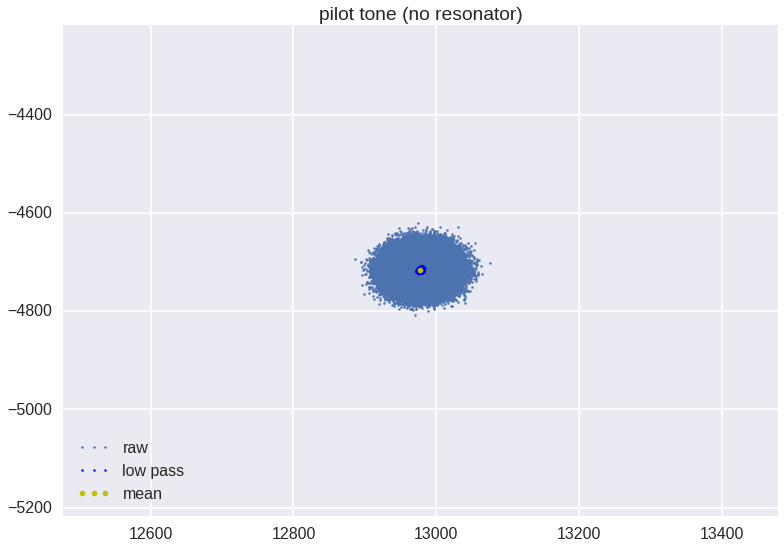

In [206]:
ss = ssoff7[0]
#plot_ri(ss.sweep.s21_point,'.')
plot_ri(ss.stream.s21_raw,'.',ms=5,label='raw')
lp = lpf(ss.stream.s21_raw,cutoff=cutoff,num_taps=num_taps,decimate_by=decimate_by)
plot_ri(lp,'b.',ms=5,label='low pass')
plot_ri(ss.stream.s21_point,'y.',label='mean')
mid = lp.mean()
xlim(mid.real-500,mid.real+500)
ylim(mid.imag-500,mid.imag+500)
legend(loc='lower left',numpoints=3)
title('pilot tone (no resonator)')

# Frequency fluctuation time series

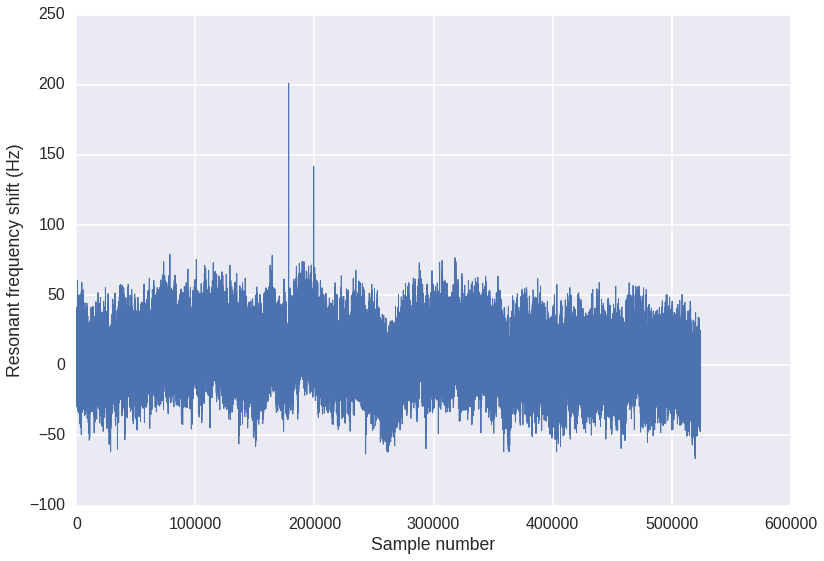

In [224]:
ss = ssoff0[0]
plot(ss.x*ss.sweep.resonator.f_0,lw=1)
ylabel('Resonant frequency shift (Hz)')
xlabel('Sample number')
#plot(ss.q)

# Fractional fluctuation time series

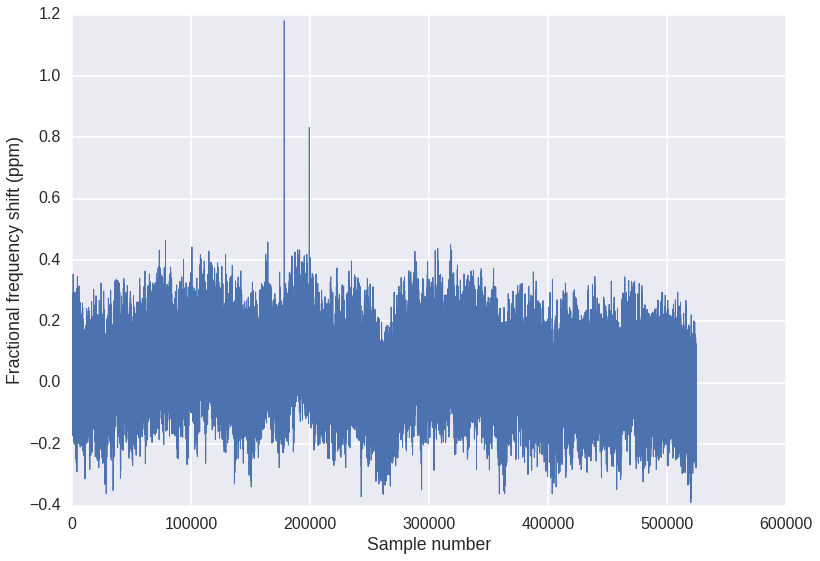

In [225]:
ss = ssoff0[0]
plot(ss.x*1e6,lw=1)
ylabel('Fractional frequency shift (ppm)')
xlabel('Sample number')

# Noise spectra

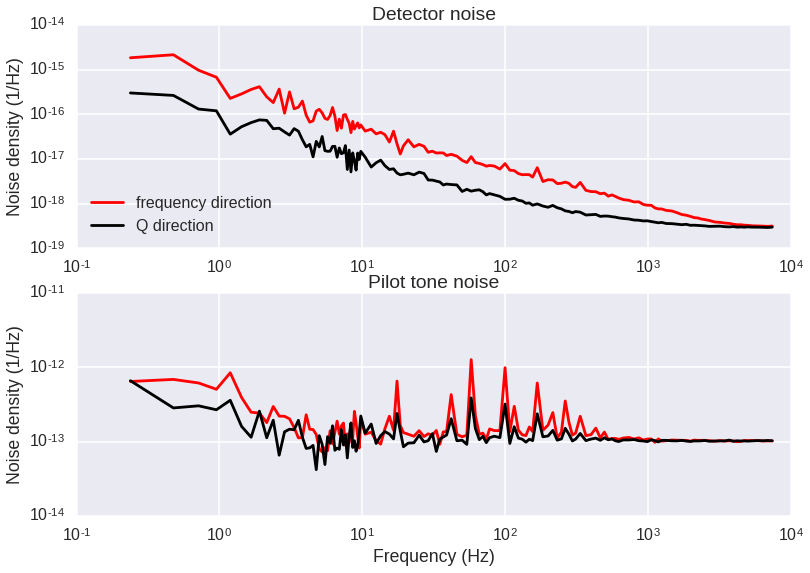

In [219]:
subplot(211)
ss = ssoff0[0]
title('Detector noise')
loglog(ss.S_frequency,ss.S_xx,'r',label='frequency direction')
loglog(ss.S_frequency,ss.S_yy,'k',label='Q direction')
legend(loc='lower left')
ylabel('Noise density (1/Hz)')
subplot(212)
title('Pilot tone noise')
ss = ssoff7[0]
loglog(ss.S_frequency,ss.S_xx,'r')
loglog(ss.S_frequency,ss.S_yy,'k')
legend(loc='lower left')
ylabel('Noise density (1/Hz)')
xlabel('Frequency (Hz)')


# Closer look at detector noise

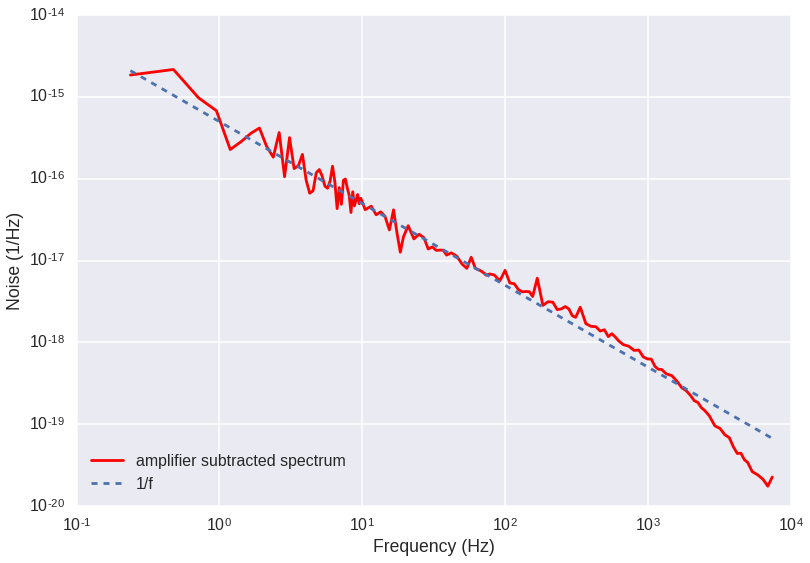

In [216]:
ss = ssoff0[0]
loglog(ss.S_frequency,ss.S_xx-ss.S_yy.min(),'r',label='amplifier subtracted spectrum')
loglog(ss.S_frequency,5e-16/ss.S_frequency,'--',label='1/f')
legend(loc='lower left')
ylabel('Noise density (1/Hz)')
xlabel('Frequency (Hz)')

In [191]:
legend?

In [57]:
def process_one(nc):
    ledmod = basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray3)
    ledon = basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray2)
    ledoff = basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray1)
    dfon = ledon.to_dataframe()
    dfoff = ledoff.to_dataframe()    
    dfmod = ledmod.to_dataframe()
    return pd.concat((dfon,dfoff,dfmod),ignore_index=True)


In [58]:
df = pd.concat([process_one(nc) for nc in ncs],ignore_index=True)

In [59]:
df.shape

(144, 64)

4


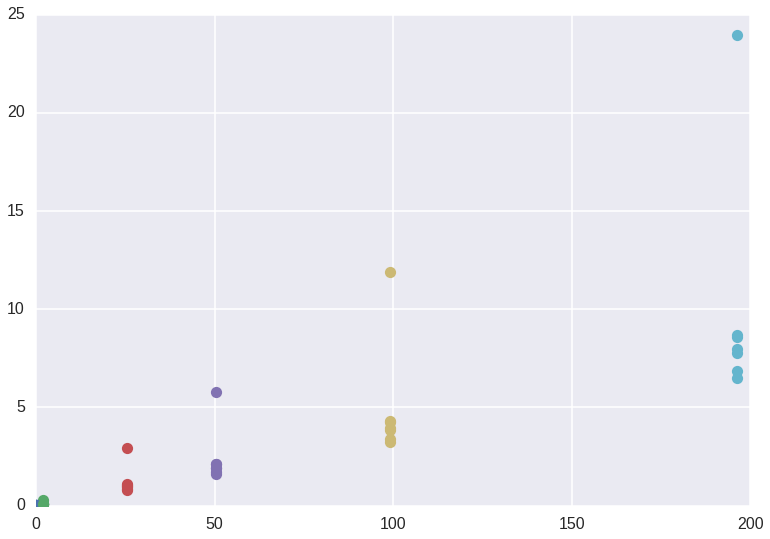

In [119]:
for n in range(7):
    dd = df[df.number==n]
    for k,row in dd.iterrows():
        if np.any(np.isnan(row.folded_x)):
            continue
        plot(1e6*1e-2*row.sourcemeter_current*row.sourcemeter_voltage,1e6*np.ptp(row.folded_x),'o')
        if np.ptp(row.folded_x)*1e6 > 20:
            print row.number
        #print row.sourcemeter_current,np.ptp(row.folded_x)*1e6
#xscale('log')
#yscale('log')

In [99]:
nc = ncs[0]
ledmod = basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray3)
ledon = basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray2)
ledoff = basic.SweepStreamArray(nc.SweepArray0,nc.StreamArray1)

In [100]:
modss=ledmod.sweep_stream(0)

In [101]:
on0 = ledon.sweep_stream(0)

In [114]:
ss0 = ledoff.sweep_stream(0)
ss7 = ledoff.sweep_stream(7)
ss4 = ledoff.sweep_stream(4)

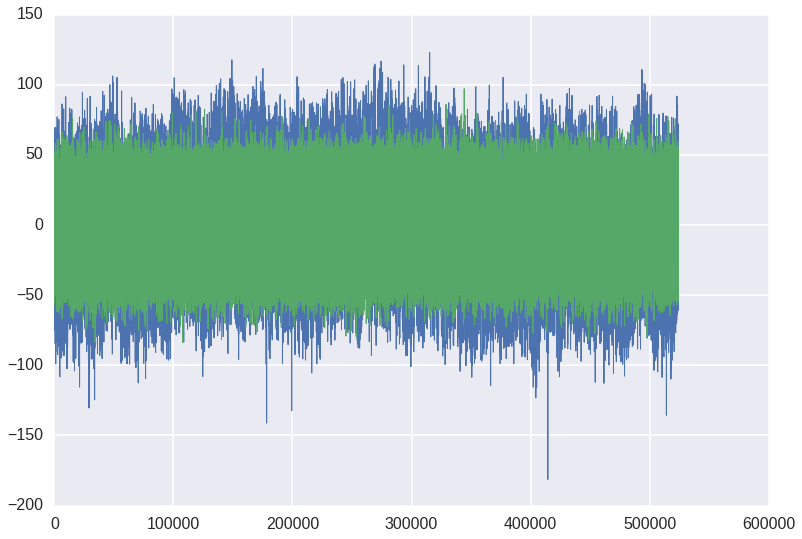

In [115]:
plot(ss0.stream.s21_raw-ss0.stream.s21_raw.mean(),lw=1)
plot(ss7.stream.s21_raw-ss7.stream.s21_raw.mean(),lw=1)
#xlim(0,1000)

In [116]:
cutoff=1/128.
decimate_by = 128
num_taps = 1024
lp0 = lpf(ss0.stream.s21_raw-ss0.stream.s21_raw.mean(dtype='complex'),cutoff=cutoff,num_taps=num_taps,decimate_by=decimate_by)
lp7 = lpf(ss7.stream.s21_raw-ss7.stream.s21_raw.mean(dtype='complex'),cutoff=cutoff,num_taps=num_taps,decimate_by=decimate_by)
lp4 = lpf(ss4.stream.s21_raw-ss4.stream.s21_raw.mean(dtype='complex'),cutoff=cutoff,num_taps=num_taps,decimate_by=decimate_by)


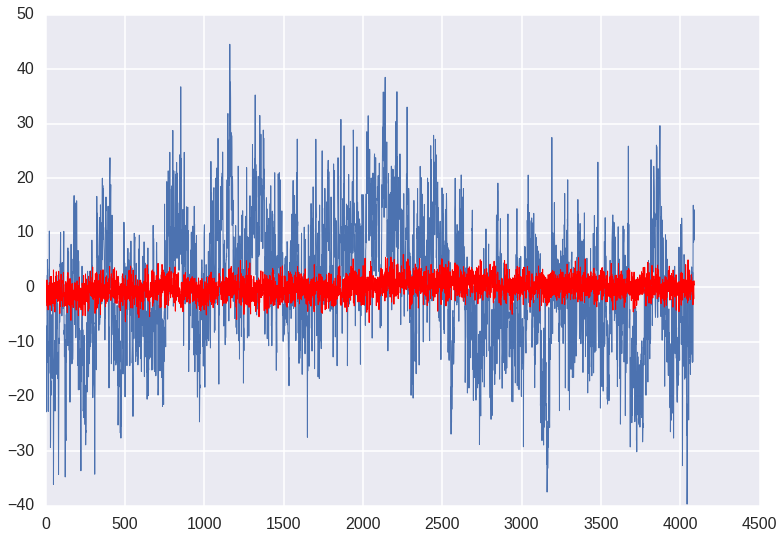

In [117]:
plot(lp0,lw=1)
plot(lp7,lw=1,color='r')

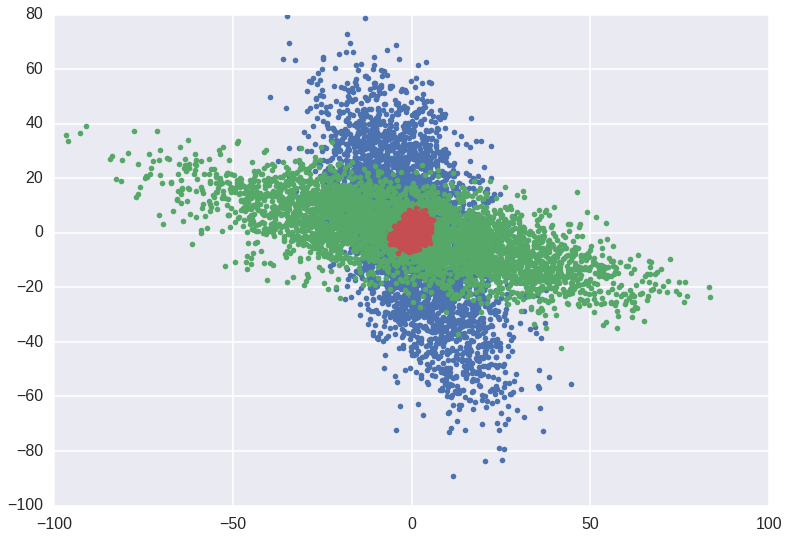

In [118]:
plot_ri(lp0,'.')
plot_ri(lp4,'.')
plot_ri(lp7,'.')


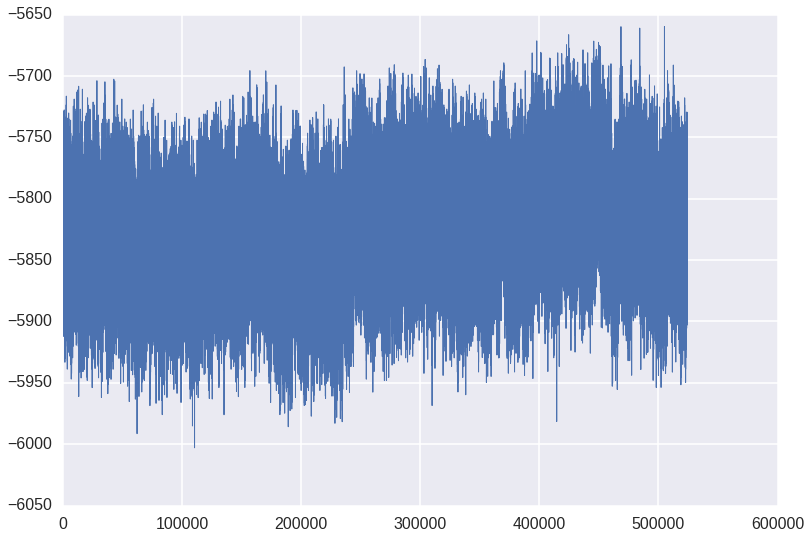

In [107]:
plot(ss4.stream.s21_raw.imag,lw=1)

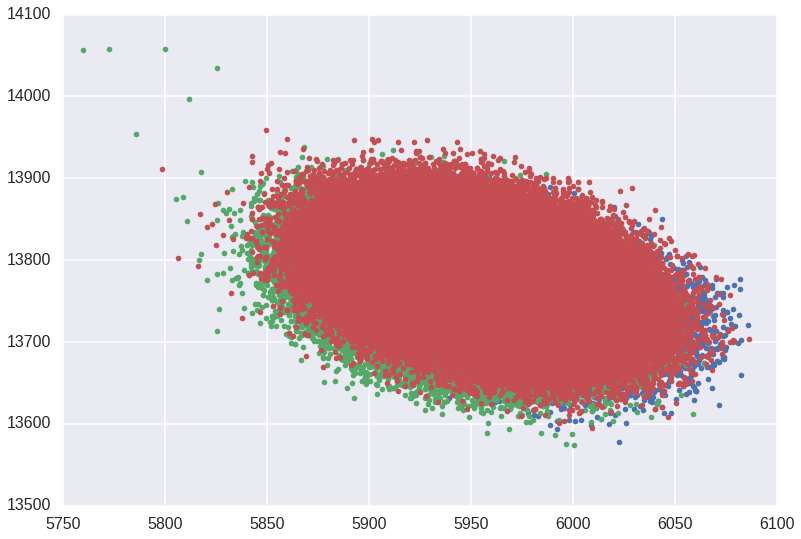

In [108]:
plot_ri(modss.stream.s21_raw,'.')
plot_ri(ss0.stream.s21_raw,'.')
plot_ri(on0.stream.s21_raw,'.')


In [36]:
df = ledmod.to_dataframe(deglitch=False)

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


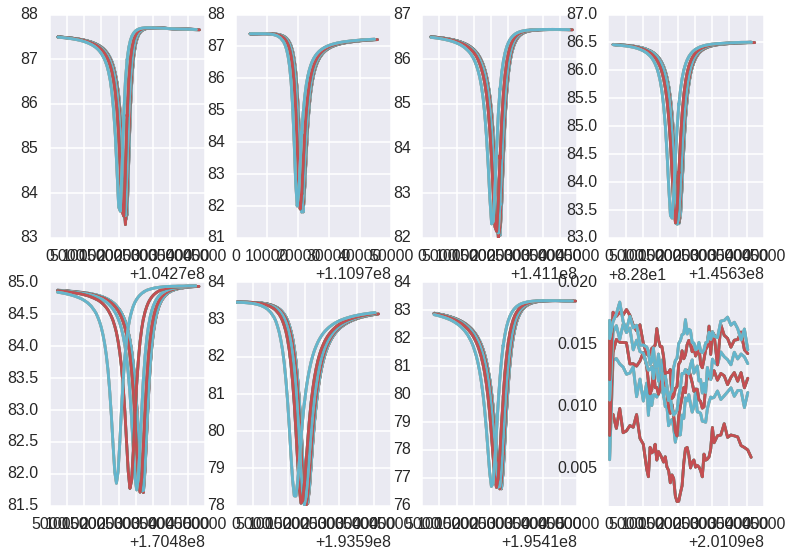

In [121]:
fig,axs = subplots(2,4)
for k,row in df.iterrows():
    ax = axs.flatten()[row.number]
    ax.plot(row.res_frequency_data,20*np.log10(np.abs(row.res_s21_data)))
    #print row.res_Q,row.number

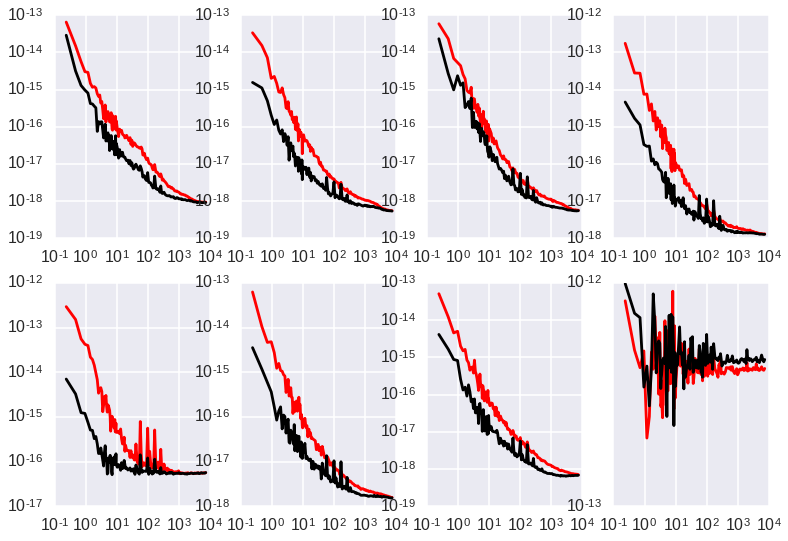

In [42]:
fig,axs = subplots(2,4)
for k,row in dfon.iterrows():
    ax = axs.flatten()[k]
    ax.loglog(row.S_frequency,row.S_xx,color='r')
    ax.loglog(row.S_frequency,row.S_yy,color='k')
    

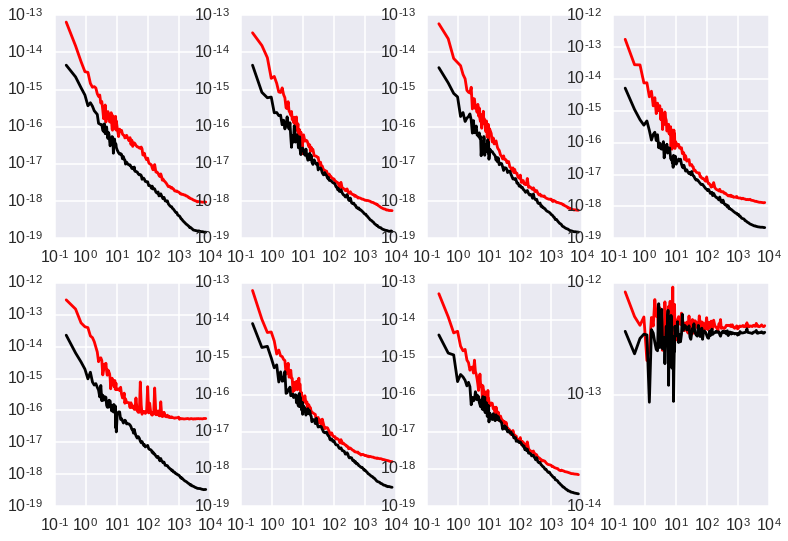

In [37]:
fig,axs = subplots(2,4)
for k,row in dfon.iterrows():
    ax = axs.flatten()[k]
    ax.loglog(row.S_frequency,row.S_xx,color='r')
for k,row in dfoff.iterrows():
    ax = axs.flatten()[k]
    ax.loglog(row.S_frequency,row.S_xx,color='k')

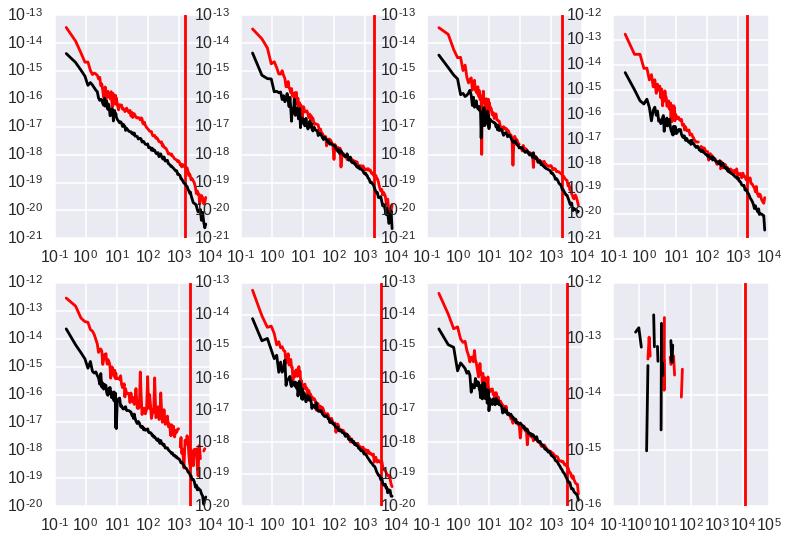

In [40]:
fig,axs = subplots(2,4)
for k,row in dfon.iterrows():
    ax = axs.flatten()[k]
    try:
        ax.loglog(row.S_frequency,row.S_xx-row.S_yy,color='r')
    except:
        pass
    ax.axvline(row.res_f_0/(2*row.res_Q),color='r')
for k,row in dfoff.iterrows():
    ax = axs.flatten()[k]
    try:
        ax.loglog(row.S_frequency,row.S_xx-row.S_yy,color='k')
    except:
        pass
    #ax.axvline(row.res_f_0/(2*row.res_Q),color='k')

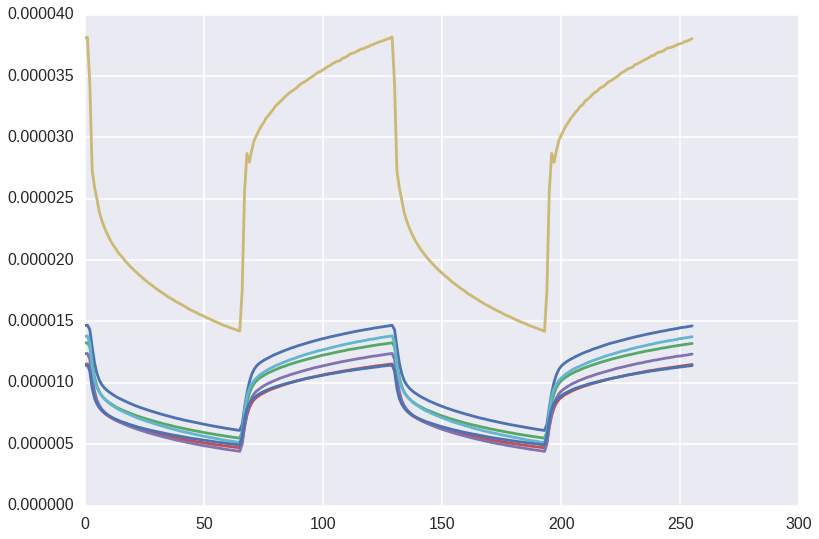

In [41]:
for k,row in df.iterrows():
    if k < 7:
        plot(row.folded_x)
    

In [35]:
row.index

Index([                      u'S_frequency',
                                    u'S_qq',
                                    u'S_xx',
                                    u'S_yy',
                          u'analysis_epoch',
                   u'folded_normalized_s21',
                                u'folded_q',
                                u'folded_x',
                             u'led_current',
                                  u'number',
                               u'res_A_mag',
                         u'res_A_mag_error',
                             u'res_A_slope',
                       u'res_A_slope_error',
                                   u'res_Q',
                                 u'res_Q_e',
                            u'res_Q_e_imag',
                      u'res_Q_e_imag_error',
                            u'res_Q_e_real',
                      u'res_Q_e_real_error',
                             u'res_Q_error',
                                 u'res_Q_i',
          